In [3]:
# Useful starting lines
%matplotlib inline

import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from test_utils import test
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Support Vector Machines
## Classification Using SVM
Load dataset. We will use a toy dataset from sklearn.

In [85]:
from sklearn import datasets

#Load dataset
sklearn_dataset = datasets.load_breast_cancer()
Xx  = sklearn_dataset.data
y = sklearn_dataset.target * 2 - 1    # labels must be in {-1, 1} for the hinge loss
X = np.ones((Xx.shape[0], Xx.shape[1] + 1 ))   
X[:, :-1] = Xx
print("(N, D) =", X.shape)

(N, D) = (569, 31)


## Prepare cost and prediction functions

In [40]:
def hinge(x):
    """
    >>> hinge(np.array([3.0, 1.0, -1.0]))
    array([0., 0., 2.])
    """
    x = 1-x
    return np.maximum(x, 0)

In [41]:
test(hinge)

✅ Your `hinge` passed 1 tests.


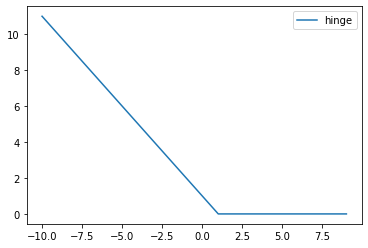

In [42]:
x = np.arange(-10,10)
y = hinge(x)
plt.plot(x, y, label='hinge')
plt.legend()
plt.show()

In [60]:
def calculate_primal_objective(y, X, w, lambda_):
    """compute the full cost (the primal objective, equation (1) in the exercise pdf),
        that is loss plus regularizer.
        
    Args:
        X: the full dataset matrix, shape = (num_examples, num_features)
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        w: shape = (num_features)
    
    Returns:
        scalar, non-negative
        
    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1, 2, 3], [4, 5, 6]])
    >>> w_test = np.array([0, 1, 5])
    >>> calculate_primal_objective(y_test, x_test, w_test, 1)
    49.0
    """
    return np.sum(hinge(np.multiply(y, (X @ w)))) + 0.5 * lambda_ * np.sum(w**2)

In [61]:
test(calculate_primal_objective)

✅ Your `calculate_primal_objective` passed 4 tests.


In [19]:
def calculate_accuracy(y, X, w):
    """compute the accuracy on the given dataset (X, y) using the model w.
    
    Args:
        X: the full dataset matrix, shape = (num_examples, num_features)
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        w: shape = (num_features)
    
    Returns:
        scalar, between 0 and 1
        
    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1, 2, 3], [4, 5, 6]])
    >>> w_test = np.array([0, 1, 5])
    >>> calculate_accuracy(y_test, x_test, w_test)
    0.5
    """
    pred =  np.sign(X @ w)
    res = (pred == y)
    return res.mean()

In [20]:
test(calculate_accuracy)

✅ Your `calculate_accuracy` passed 4 tests.


## Stochastic Gradient Descent for SVM

Compute the (stochastic) subgradient for the n-th summand of the SVM optimization objective

In [82]:
def calculate_stochastic_gradient(y, X, w, lambda_, n, num_examples):
    """compute the stochastic gradient of loss plus regularizer.
    
    Args:
        X: the dataset matrix, shape = (num_examples, num_features)
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        w: shape = (num_features)
        lambda_: positive scalar number
        n: the index of the (one) datapoint we have sampled
        num_examples: N
    
    Returns:
        numpy array, shape = (num_features)
    
    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1, 2, 3], [4, 5, 6]])
    >>> w_test = np.array([0, 1, 5])
    >>> calculate_stochastic_gradient(y_test, x_test, w_test, 1, 1, 2)
    array([ 8, 11, 17])
    >>> calculate_stochastic_gradient(y_test, x_test, w_test, 1, 0, 2)
    array([0, 1, 5])
    """
    # Be careful about the constant N (size) term!
    # The complete objective for SVM is a sum, not an average as in earlier SGD examples!

    x_n, y_n = X[n], y[n]
    grad = np.maximum(-y_n * x_n.T, 0)
    # calculate the sum of the gradient based on one point
    grad = num_examples * grad + lambda_ * w
    return grad


In [83]:
test(calculate_stochastic_gradient)

✅ Your `calculate_stochastic_gradient` passed 5 tests.


Implement stochastic gradient descent: Pick a data point uniformly at random and update w based on the gradient for the n-th summand of the objective

In [87]:
def sgd_for_svm_demo(y, X):
    
    max_iter = 2 * int(1e5)
    gamma = 1e-5
    lambda_ = int(1e4)   # big because scales with N due to the formulation of the problem (not an averaged loss)

    num_examples, num_features = X.shape
    w = np.zeros(num_features)
    
    for it in range(max_iter):
        # n = sample one data point uniformly at random data from x
        n = random.randint(0,num_examples-1)
        
        grad = calculate_stochastic_gradient(y, X, w, lambda_, n, num_examples)
        w -= gamma / (it+1) * grad   
        
        if it % 20000 == 0:
            cost = calculate_primal_objective(y, X, w, lambda_)
            print("iteration={i}, cost={c}".format(i=it, c=cost))
            
    print("training accuracy = {l}".format(l=calculate_accuracy(y, X, w)))


sgd_for_svm_demo(y, X)

iteration=0, cost=569.0
iteration=20000, cost=9178000.64728835
iteration=40000, cost=9611012.845701383
iteration=60000, cost=9844739.326057361
iteration=80000, cost=10011399.747963587
iteration=100000, cost=10130266.143759213
iteration=120000, cost=10230804.874918012
iteration=140000, cost=10317709.238655444
iteration=160000, cost=10392685.869165376
iteration=180000, cost=10457518.25162384
training accuracy = 0.37258347978910367


## Coordinate Descent (Ascent) for SVM

Compute the closed-form update for the n-th variable alpha, in the dual optimization problem, given alpha and the current corresponding w

In [ ]:
def calculate_coordinate_update(y, X, lambda_, alpha, w, n):
    """compute a coordinate update (closed form) for coordinate n.
    
    Args:
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        X: the dataset matrix, shape = (num_examples, num_features)
        lambda_: positive scalar number
        alpha: vector of dual coordinates, shape = (num_examples)
        w: vector of primal parameters, shape = (num_features)
        n: the coordinate to be updated
        
    Returns:
        w: updated vector of primal parameters, shape = (num_features)
        alpha: updated vector of dual parameters, shape = (num_examples)
        
    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1., 2., 3.], [4., 5., 6.]])
    >>> w_test = np.array([-0.3, -0.3, -0.3])
    >>> alpha_test = np.array([.1, .1])
    >>> calculate_coordinate_update(y_test, x_test, 1, alpha_test, w_test, 0)
    (array([-0.1,  0.1,  0.3]), array([0.3, 0.1]))
    """        
    # calculate the update of coordinate at index=n.
    x_n, y_n = X[n], y[n]
    old_alpha_n = np.copy(alpha[n])
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************
    raise NotImplementedError

    return w, alpha

In [ ]:
test(calculate_coordinate_update)

In [ ]:
def calculate_dual_objective(y, X, w, alpha, lambda_):
    """calculate the objective for the dual problem.
    
    Args:
        y: the corresponding +1 or -1 labels, shape = (num_examples)
        X: the dataset matrix, shape = (num_examples, num_features)
        w: vector of primal parameters, shape = (num_features)
        alpha: vector of dual coordinates, shape = (num_examples)
        lambda_: non negative scalar number

    Output:
        scalar

    >>> y_test = np.array([1, -1])
    >>> x_test = np.array([[1., 2., 3.], [4., 5., 6.]])
    >>> w_test = np.array([-0.3, -0.3, -0.3])
    >>> alpha_test = np.array([.1, .1])
    >>> calculate_dual_objective(y_test, x_test, w_test, alpha_test, 1)
    0.065
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO
    # ***************************************************
    raise NotImplementedError


In [ ]:
test(calculate_dual_objective)

In [ ]:
# Notice that the gap is going to 0
def coordinate_descent_for_svm_demo(y, X):
    max_iter = 2*int(1e5)
    lambda_ = int(1e4)

    num_examples, num_features = X.shape
    w = np.zeros(num_features)
    alpha = np.zeros(num_examples)
    
    for it in range(max_iter):
        # n = sample one data point uniformly at random data from x
        n = random.randint(0,num_examples-1)
        
        w, alpha = calculate_coordinate_update(y, X, lambda_, alpha, w, n)
            
        if it % 20000 == 0:
            # primal objective
            primal_value = calculate_primal_objective(y, X, w, lambda_)
            # dual objective
            dual_value = calculate_dual_objective(y, X, w, alpha, lambda_)
            # primal dual gap
            duality_gap = primal_value - dual_value
            print('iteration=%i, primal:%.5f, dual:%.5f, gap:%.5f'%(
                    it, primal_value, dual_value, duality_gap))
    print("training accuracy = {l}".format(l=calculate_accuracy(y, X, w)))

coordinate_descent_for_svm_demo(y, X)